# Final Project: Prediction of User Churn for a Level-breaking Mobile Game

## Summary

The loss of new users becomes a serious problem for level-breaking mobile games. Our task is to predict players' churn or stay based on their game log within a certain time range.  

The AUC scores mostly stabled at around 0.7911 on the test set with different models, such as Bagging(estimator amount: 50) with Decision Tree(Gini, Depth:3, Minimum Split:50) as the base classifier and MLP(Relu activation, iterate: 1000, hidden layer: (20,20)). A paired T-test is run on these final models with similar AUC scores, among which  Bagging(estimator n=50) + LogisticRegression(solver: lbfgs, C: 1.0) has the most significant difference statistically.    

Data used for learning are constructed from the game's raw record log. Two data sets are built for parameter tuning. One of which is weighted by the game level complexity, generated from the average pass rate of each game level.  The best performances so far are all using the weighted data. Shapley values, cross validations and ablation study are used to analyze the feature explainability and importance. Under this task and with our weighted data model, ensemble algorithm and MLP works better than single classifiers. Most of the best performances from Ensemble and MLP converge to the same AUC. Therefore, an improvement could potentially be made if we polish our data set by introducing bias or adding in features that have more significant impact over the classification decision.     

For extended experiments, we also tried re-construct data sets with less manual interference and other learning models. It is as expected that the training result drops with the data set that is closer to the raw data. The reason being in the original data construct, calculations such as weighted sum and arithmetic mean have smoothed the outliers and averaged out noises. These lower scores are a more true reflection of the raw data.


## Introduction
  
Mobile games have a dominant position in today's daily entertainment. Various types of mobile games, especially level-breaking genres, have gained a very wide market as they allow users to utilize their fragmented time.  

However, the loss of new users becomes a serious problem for this type of games. A significant proportion of users choose to drop the game after a short try. By interfering users (such as with reward props) before they unistall the game, it is possible to restore users and increase the activity of the game and the company's potential revenue. Therefore, predicting user churn has become an important and challenging issue.  

In this experiment, we will construct a reasonable model from unstructured log data to make such prediction.

## Data Overview
  
The data is from a casual level-breaking mobile game. The basic task of each level is to reach a certain goal within a limited number of steps. Users only enter the next level after completing one level. They can use props or prompts to help during the level.  

For most mobile games, users decide to quit often at the early stages of games, so retention in the second week after game release is a focus of the company. Our data selects the interaction log from 2.1-2.4 of all users registered on February 1, 2020. The data is filtered to ensure that these users have logged in on at least two days within the time range.  And churn is when such a user does not log in in the next week(2.7-2.13).  
  
Data here is in a form of raw data record, that is closer to the company's log form.  

In [1]:
import pandas as pd
import numpy as np

import sys
import datetime

import missingno as msno
import seaborn as sb
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

RANDOM_SEED = 2020 # random seed from sample code

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1. Data Read-In

There are in total five data files.  
This section mainly reads in the data files, understands what kind of data they contains and how to use them to construct the data model for training.

### 1.1 train.csv
  
User IDs abd associated labels collected for the train set. Label 1 suggests churn, and 0 means stay.

In [2]:
# label 1 --> churn; label 0 --> stay
train_df = pd.read_csv('./data/train.csv', sep='\t')

In [3]:
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,...,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,0


In [4]:
train_df['label'].value_counts()

0    5428
1    2730
Name: label, dtype: int64

The train set contains 8158 users, 1/3 among which are identified as churn.   

It should be noted that in order to keep anonymity, data in this experiment have undergone certain non-uniform sampling processing. The churn rate here does not fully reflect the actual game situation. Users' IDs and levels' IDs have both been re-numbered, but should have no impact regarding our main task.

### 1.2 dev.csv  
  
User IDs and associated labels collected for the validation set. Labels are the same as in the train set. This provides convinience for parameter sensitivity testing, ablation study and model choosing.

In [5]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


### 1.3 test.csv  
This is the test set. Only user Ids are contained within this file.  
Our main goal is to predict churn probability on these users.

In [6]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


### 1.4 level_seq.csv  

This is the core data. It contains the records of each game level on a per-player/user base. One record associates with one attempt at a game level.  

The meaning of each column is as follows:
  
* `user_id`：User's ID, so that data can match with the train/validation/test sets from above;  
* `level_id`：ID number of a level in game;  
* `f_success`：Whether a user has completed the level. 1 is success, and 0 is fail;  
* `f_duration`：Time spent(in second) on a level; 
* `f_reststep`：Ratio of remaining steps to limited steps amount; If fail to complete a level, the ration is 0;  
* `f_help`：Whether a user has used help props in attempt. 1 is used, and 0 is not used;  
* `time`：Time stamp; We could use this to identify whether a user has logged into the game.

In [7]:
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


### 1.5 level_meta.csv  
Statistic features and data for a game level. Note: this is not user-related.  
  
* `f_avg_duration`：Average time spent to complete a level(in second, including all attemps);
* `f_avg_passrate`：Average pass rate;  
* `f_avg_win_duration`：Average time spent to complete a level(in second, only on the attemp that passes the level);  
* `f_avg_retrytimes`：Average re-try/re-play times;  
* `level_id`：Level ID that can match with the sequence data in Section 1.4.

In [16]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


## 2. Data Pre-processing

We will use the information from Section 1 to construct data that could represent the users more.  
To be noted: our data has to construct from a user-oriented dimension.  

First all data features that we could think of to represent a user will be calculated and constructed. Then we will analyze all these features and decides whether to keep the feature or not.

### 2.1 Time Stamp Related Data

We will focus on the time stamp data from the sequence collection. This portrayed users from a more personal perspective. 

1. `days`: log in days amount; If a user keeps logging in for most of the days, then it is possible that they will stay for daily register or some other daily activities.  

2. `logins`: will use a threshold between time stamps to determine whether there is a new login happens. We could use it to evaluate users' addiction. This may not be accurate since users could also keep playing for a long time without re-logging in.  
3. `dailytime`: measure users' addiction from another dimension, make up a deficiency desscibed in 2.  

4. `enddate`: last day a user has logged into the game.  

### 2.2 User Experience Related Data

ref: https://www.blog.udonis.co/mobile-marketing/mobile-games/churn-rate  
ref: https://en.wikipedia.org/wiki/Curse_of_dimensionality#:~:text=The%20curse%20of%20dimensionality%20refers,physical%20space%20of%20everyday%20experience.  

When it comes to in-game and external features that can chase the users away, **game complexity** can have huge impact.   
This feature can be analyzed from different dimensions:  

1. whether the game gives a user a good first-time experience, in general, that is if the first level(usually known as beginner's tutorial) is clear enough for him or her to understand. We could measure this by the ratio of a user's time spent for passing the first level to the average duration in level meta data.

2. whether the game is complex enough:
> - a. Max level a user has accomplished.
> - b. Max retry times a user has tried. 
> - c. Average times a user has used help props within the logged time range.
> - d. Ratio of remaining steps to limited steps amount; If fail to complete a level, the ration is 0 (per level).
> - e. Ratio of retry times to average retry times (per level); If retry times is zero, the ratio is 0; Potential risk is that when average retry times is too small and the ratio becomes too large; Therefor we might use the difference between two numbers instead.
> - f. Ratio of time a user spent on a level to the level's average duration (per level);
> - g. If a user keeps failing on one level or few levels, there is high potential that they will lose patience and quit the game; Therefore, we will take the last 20 records for one user and calculates the rate they accomplish a level.
> - h. Ratio of wins to the total amount of attemps

Given the upper analysis, below are the features we need to construct:  

**Per-Level Base**
- `timespent`: (2.f)
- `retry`: (2.e)
- `remainstep`: (2.d)

**Others**
- `firstlevel`: (1)
- `maxlevel`: (2.a)
- `maxtry`: (2.b)
- `propuse`: (2.c)
- `winrate`: (2.h)
- `lastwinrate`: (2.g)


There are in total 1509 levels logged in our data. There is a huge chance that we encounter <mark>"the curse of dimensionality"</mark> if we have three features at per-level base.  
An optimization may be to have an arithmetic mean on the ratios(Note: we only take account the levels users have accomplished). The mean value can be calculated with uniform weights, or with the weights that derived from the average pass rates. 

In fact, we will use the optimization method first, and switch back if the learning result is not ideal.

**This is the dataframe holding constructed date for all logged users**

In [ ]:
user_ids = np.sort(seq_df["user_id"].unique())

In [ ]:
all_user_info = pd.DataFrame()
all_user_info["user_id"] = user_ids

### 2.3 Construct Time Stamp Related features

In [ ]:
sort_seq_df = seq_df.sort_values(['user_id', 'level_id'])

In [ ]:
# we will convert the existing "time" feature to date and time

# msno.matrix(sort_seq_df) no missing data exists

def get_date_and_time(data):
    data_split = data.split(" ")

    day = int(data_split[0].split("-")[2])
    time = datetime.datetime.strptime(data, "%Y-%m-%d %H:%M:%S")
    
    return day, time

In [ ]:
months, days, time_info = [], [], []
for data in sort_seq_df["time"]:
    day, time = get_date_and_time(data)
    days.append(day)
    time_info.append(time)
    
sort_seq_df.drop(columns=["time"], inplace=True)
sort_seq_df['day'], sort_seq_df['time'] = [days, time_info]

In [ ]:
sort_seq_df

#### 2.3.1 Feature "days"

In [ ]:
days = []
for user in all_user_info["user_id"]:
    login_days = len(sort_seq_df.query("user_id=={}".format(user))["day"].unique())
    days.append(login_days)
    
all_user_info["days"] = days

#### 2.3.2 Feature "enddate"

In [ ]:
enddates = []
for user in all_user_info["user_id"]:
    last_login_day = np.max(sort_seq_df.query("user_id=={}".format(user))["day"])
    enddates.append(last_login_day)
    
all_user_info["enddate"] = enddates

#### 2.3.3 Feature "logins"

In [ ]:
login_times = []
# we will identify a new login only if two time stamps have a difference more than 0.5 hour (1800 sec)
threshold = 1800

for user in all_user_info["user_id"]:
    login_amount = 1
    time_stamps = list(sort_seq_df.query("user_id=={}".format(user))["time"])
    
    i = 1
    
    if len(time_stamps) <= 1:
        login_times.append(1)
    else:
        while i<len(time_stamps):
            delta = time_stamps[i] - time_stamps[i-1]
            if delta.total_seconds()>threshold:
                login_amount += 1
            i += 1
        login_times.append(login_amount)

all_user_info["logins"] = login_times

#### 2.3.4 Feature "dailytime"

We will simply add all level duration time for a user and divide by time range 4(2.1-2.4).

In [ ]:
daily_times = []

for user in all_user_info["user_id"]:
    f_times = sort_seq_df.query("user_id=={}".format(user))["f_duration"]
    daily_times.append(np.sum(f_times)/4)

all_user_info["dailytime"] = daily_times

### 2.4 Construct User Experience Related features

#### 2.4.1 Feature "maxlevel", "maxtry" and "propuse"

In [ ]:
def continuous_set(s):
    return (np.diff(s)==1).all()

In [ ]:
max_levels = []
max_tries = []
prop_uses = []

for user in all_user_info["user_id"]:
    # prop use is the daily average
    f_helps = sort_seq_df.query("user_id=={}".format(user))["f_help"]
    prop_uses.append(np.sum(f_helps)/4)
    
    # max levels a user has achieved
    pass_levels = sorted(set(sort_seq_df.query("user_id=={} & f_success==1".format(user))["level_id"]))
    if not pass_levels:
        max_levels.append(0)
    else:
        # if passed levels are continuous
        if continuous_set(pass_levels):
            # if the last pass level is out of the 1509 levels
            if pass_levels[-1]>1509:
                max_levels.append(1509)
            else:
                max_levels.append(pass_levels[-1])
        # if passed levels are not continuous
        # still append the max levels but warn forehead
        else:
            sys.stderr.write("Missing info for user {}; Logged passed levels are not continuous! \n".format(user))
            if pass_levels[-1]>1509:
                max_levels.append(1509)
            else:
                max_levels.append(pass_levels[-1])
            
    # max try
    user_filter = sort_seq_df.query("user_id=={}".format(user))
    levels = user_filter["level_id"].unique()
    max_try = 0
    for level in levels:
        fail_attemps = len(user_filter.query("level_id=={} & f_success==0".format(level)))
        if fail_attemps > max_try:
            max_try = fail_attemps
    max_tries.append(max_try)
    

In [ ]:
all_user_info["maxlevel"] = max_levels
all_user_info["maxtry"] = max_tries
all_user_info["propuse"] = prop_uses

#### 2.4.2 Feature "firstlevel", "winrate" and "lastwinrate"

In [ ]:
first_levels = []
win_rates = []
last_win_rates = []

for user in all_user_info["user_id"]:
    
    # the ratio of a user's time spent for passing the first level to the average duration
    first_ratio_attemps = sort_seq_df.query("user_id=={} & level_id==1".format(user))["f_duration"]
    ratio = np.sum(first_ratio_attemps)/meta_df["f_avg_duration"][0]
    first_levels.append(ratio)
    
    filter_data = sort_seq_df.query("user_id=={}".format(user))
    if len(filter_data)==0:
        win_rates.append(0)
        last_win_rates.append(0)
    
    else:
        # ratio of wins to the total amount of attemps
        ratio = len(filter_data.query("f_success==1"))/len(filter_data)
        win_rates.append(ratio)

        # last 20 records for one user and calculates the rate accomplish a level
        if len(filter_data)<20:
            last_win_rates.append(ratio)
        else:
            last_attemps = filter_data[-20:]
            last_win_rates.append(len(last_attemps.query("f_success==1"))/20)

In [ ]:
all_user_info["firstlevel"] = first_levels
all_user_info["winrate"] = win_rates
all_user_info["lastwinrate"] = last_win_rates

In [ ]:
all_user_info

#### 2.4.3 Feature "timespent", "remainstep" and "retry"

The original plan is to construct each feature on a per-level base. Based on the analysis in Section 2.2, we will first use average values for optimization and to avoid high-dimensionality.  

In this section, we introduce two ways to calculate average: arithmetic mean and weighted mean.  
We will run simple classifiers on data sets constructed by these two different methods, and evaluate which one is more representetive.

**Get Weights from Average Passrate**: the lower the passrate is, the more difficult the level is for general users, and the heavier the weight will be.

In [ ]:
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

In [ ]:
def get_weights_from_passrate(data):
    with np.errstate(divide='ignore', invalid='ignore'):
        weights = np.true_divide(1,data)
        weights[weights == np.inf] = 0
        weights = np.nan_to_num(weights)
    return normalize(weights)  

In [ ]:
passrate_weights = get_weights_from_passrate(meta_df["f_avg_passrate"])

**Get Average for User Experience Data**

In [ ]:
def get_user_mean(user_data, meta_data, user, weight_matrix, weight="passrate", cal_func="timespent"):
    # prepare information for calculating mean values
    filter_data = user_data.query("user_id=={}".format(user))
    levels = filter_data["level_id"].unique()
    data_sum = 0

    # loop through levels
    for level in levels:
        if cal_func=="timespent":
            ratio = get_level_timespent(filter_data, meta_data, level)
        if cal_func=="retry":
            ratio = get_level_retry(filter_data, meta_data, level)
        if cal_func=="remainstep":
            ratio = get_level_remainstep(filter_data, meta_data, level)

        # add per-level ratio sum
        if weight=="uniform":
            data_sum += ratio
        if weight=="passrate":
            # weights already normailized, no need to get mean
            data_sum += ratio*passrate_weights[level-1]

    # final mean calculation
    if weight=="uniform":
        return data_sum/len(levels)
    if weight=="passrate":
        return data_sum

In [ ]:
def get_level_timespent(user_data, meta_data, level):
    level_time = np.sum(user_data.query("level_id=={}".format(level))["f_duration"])
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.true_divide(level_time, meta_data["f_avg_duration"][level-1])
        if ratio == np.inf or np.isnan(ratio):
            ratio = 0
    return ratio

In [ ]:
def get_level_retry(user_data, meta_data, level):
    # -1 to exclude the first try
    retry_amount = len(user_data.query("level_id=={}".format(level)))-1
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.true_divide(retry_amount, meta_data["f_avg_retrytimes"][level-1])
        if ratio == np.inf or np.isnan(ratio):
            ratio = 0
    return ratio

In [ ]:
def get_level_remainstep(user_data, meta_data, level):
    # get the success record remain steps
    filter_success = user_data.query("level_id=={} & f_success==1".format(level))
    if len(filter_success) == 0:
        ratio = 0
    if len(filter_success) == 1:
        ratio = float(filter_success["f_reststep"])
    if len(filter_success) > 1:
        ratio = np.sum(filter_success["f_reststep"])/len(filter_success)
    return ratio

#### Uniform Weight

In [ ]:
timespent = []
retry = []
remainstep = []

for user in all_user_info["user_id"]:
    timespent_value = get_user_mean(sort_seq_df, meta_df, user, 
                               passrate_weights, weight="uniform", 
                               cal_func="timespent")
    retry_value = get_user_mean(sort_seq_df, meta_df, user, 
                               passrate_weights, weight="uniform", 
                               cal_func="retry")
    remainstep_value = get_user_mean(sort_seq_df, meta_df, user, 
                               passrate_weights, weight="uniform", 
                               cal_func="remainstep")
    timespent.append(timespent_value)
    retry.append(retry_value)
    remainstep.append(remainstep_value)

#### Passrate Weighted

In [ ]:
timespent_w = []
retry_w = []
remainstep_w = []

for user in all_user_info["user_id"]:
    timespent_value = get_user_mean(sort_seq_df, meta_df, user, 
                               passrate_weights, weight="passrate", 
                               cal_func="timespent")
    retry_value = get_user_mean(sort_seq_df, meta_df, user, 
                               passrate_weights, weight="passrate", 
                               cal_func="retry")
    remainstep_value = get_user_mean(sort_seq_df, meta_df, user, 
                               passrate_weights, weight="passrate", 
                               cal_func="remainstep")
    timespent_w.append(timespent_value)
    retry_w.append(retry_value)
    remainstep_w.append(remainstep_value)

**Now we construct two final data collection for learning**. Note: these two sets will be written out to .csv files so we could downcut the running time in the future.

In [ ]:
uniform_data_dict = {"timespent": timespent, "retry": retry, "remainstep": remainstep}
weighted_data_dict = {"timespent": timespent_w, "retry": retry_w, "remainstep": remainstep_w}


uniform_final_data = pd.concat([all_user_info, pd.DataFrame.from_dict(uniform_data_dict)], axis=1)
weighted_final_data = pd.concat([all_user_info, pd.DataFrame.from_dict(weighted_data_dict)], axis=1)

display(uniform_final_data)
display(weighted_final_data)

uniform_final_data.to_csv("./data/uniform_user_info.csv", encoding='utf-8', index=False)
weighted_final_data.to_csv("./data/weighted_user_info.csv", encoding='utf-8', index=False)

### 2.5 Correlation Analysis

**Weighted and Uniform have similar plots**  
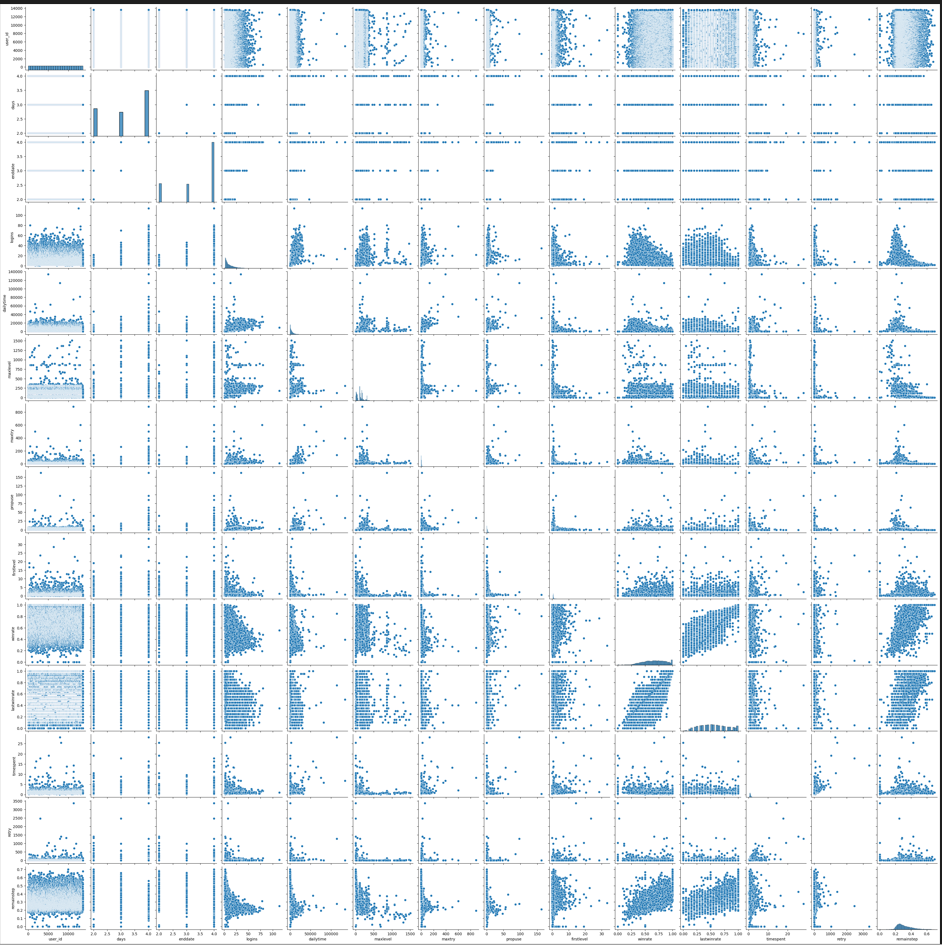  

For both uniform weighted data and passrate weighted data, high correlation pairs are the same. They are:
1. winrate - lastwinrate
2. dailytime -retry 
3. login - retry
4. login - timespent

We will not jump into any feature exclusion yet. The correlation score matrix will also be used for further evaluation.

### 2.6 Construct Train/Validation/Test Sets

In [7]:
uniform_data = pd.read_csv('./data/uniform_user_info.csv')
weighted_data = pd.read_csv('./data/weighted_user_info.csv')

**Uniform Weight Data Set**

In [8]:
# test set: index 0-2772
uniform_test_df = uniform_data.iloc[:2773]
# train set: index 2773-10931
uniform_train_df = uniform_data.iloc[2773:10931].copy()
uniform_train_df["label"] = list(train_df["label"])
# validation set: index 10932-10931
uniform_validation_df = uniform_data.iloc[10931:].copy()
uniform_validation_df["label"] = list(dev_df["label"])

**Passrate Weighted Data Set**

In [9]:
# test set: index 0-2772
weighted_test_df = weighted_data.iloc[:2773]
# train set: index 2773-10931
weighted_train_df = weighted_data.iloc[2773:10931].copy()
weighted_train_df["label"] = list(train_df["label"])
# validation set: index 10932-10931
weighted_validation_df = weighted_data.iloc[10931:].copy()
weighted_validation_df["label"] = list(dev_df["label"])

In [ ]:
correlation_matrix = weighted_train_df.corr()
plt.figure(figsize = (10,10))
sb.heatmap(correlation_matrix, cmap=sb.cubehelix_palette(as_cmap=True), annot=True, fmt=".2f")

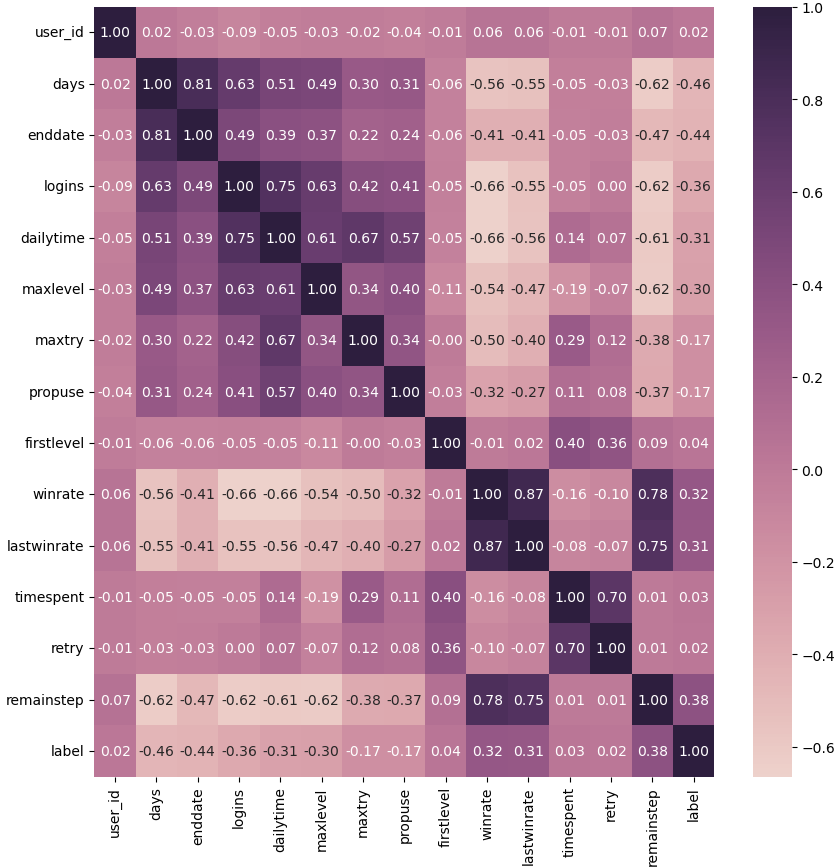

Observations:
1. Both the uniform weight data and non-uniform weight data have similar correlation matrices.  

2. Feature "first level", "time spent", and "retry" do not have high correlation with the classification labels. We will test these three features in ablation study later.   

3. Feature "winrate" and "lastwinrate" are closly connected to each other. "Days" and "enddate" are also a high-correlated pair. However, the correlation score is not too high(under 0.9), so we will not consider to rule these features out.   

For further analysis, we will use random forest classifier and shapley values to evaluate the explainability and interpretability.

### 2.7 Explainability and Interpretability

Below codes are the same for both uniform-weighted dataset and passrate-weighted dataset.

In [ ]:
feature_names = set(weighted_train_df.columns) - set(["user_id", "label"])

x_train = weighted_train_df.drop(columns=["label", "user_id"]).to_numpy()
y_train = weighted_train_df["label"].to_numpy()

rf_clf = RandomForestClassifier( n_estimators = 100,
                                 max_features = 0.2,
                                 max_depth = 10,
                                 max_samples = 0.5)
rf_clf.fit(x_train, y_train)


explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values[1], x_train, feature_names=list(feature_names), plot_type = 'dot')

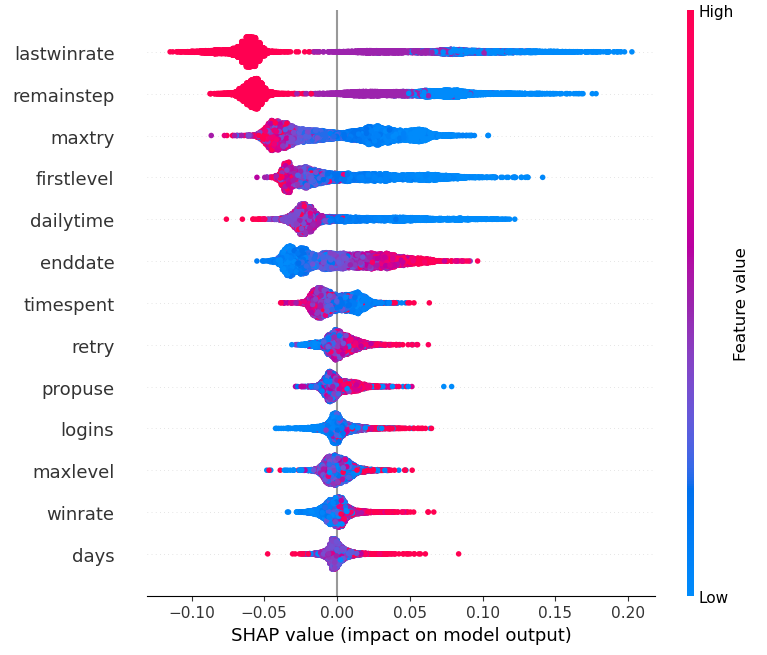

ref: https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/  

Predictive models are not easy to interpret. A recent technique to interpret models has stood out among others: SHAP (SHapley Additive exPlanations). SHAP measures the impact of variables taking into account the interaction with other variables.  

The image above has y-axis indicates the variable name, in order of importance from top to bottom. The x-axis is the SHAP value. Indicates how much is the change in log-odds.  

Feature `lastwinrate` and `remainsteps` are associated with high positive values on the target. When `lastwinrate` is high (or true) then shap value is high. Players tend to stay for the game more when they win more easily among the last attemps.  

Points in feature `days` has a comparatively large dispersion. This suggests that when this feature is close to 0, it does not affect much on the classification. 

An observation that is contrary to the previous analysis(in Section 2.6) is that feature `firstlevel` has a greater impact on the classification result. Feature `retry` and `timespent` have low Shapley values, that is, have low correlation regarding the target. Therefore, we will focus on `firstlevel` for ablation study.

### Potrait of Players 

1. Playersend dates have positive proportion to their total login days. However, these two do not contribute much on churn and stay. 
2. Time users spend on the game are closely related to their game experiences and persona(patience).
3. Players' stay or lose is closely connected to how easy they find the final few attemps(game levels)are. The game overall being too difficult or too easy can both result in user churn, due to the lack of instant gratification or challenge.
4. First-time experiences can have comparatively large impact on users' feeling to the game. 
5. A patient player is less likely to churn.
6. A player who spends less time playing the game daily is more likely to churn.

## 3. Test with Simple Classifiers

We will choose some simple classifiers to run on two data sets. The main task is to:
1. Evaluate which data set carries out better learning results;
2. Identify unstable classifiers and check if any ensemble algorithms or deep learning could introduce in improvement. 

Following classifiers are tested: DecisionTreeClassifier, LogisticRegression, Naive Bayes, and Knn. Mean scores from cross validation are used to measure the performance of classification.

In [11]:
scoring = {'accuracy' : make_scorer(accuracy_score)}

In [10]:
uniform_x_train = uniform_train_df.drop(columns=["label", "user_id"]).to_numpy()
uniform_y_train = uniform_train_df["label"].to_numpy()

weighted_x_train = weighted_train_df.drop(columns=["label", "user_id"]).to_numpy()
weighted_y_train = weighted_train_df["label"].to_numpy()

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(uniform_x_train)
norm_uniform_x_train = scaler.transform(uniform_x_train)

scaler.fit(weighted_x_train)
norm_weighted_x_train = scaler.transform(weighted_x_train)

### 3.1 Logistic Regression

ref: https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69  

We will check how logistic regressor behaves on our data sets and normalized data sets. This is inspired by: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5.  

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]

for solver in solvers:
    print(solver)
    accuracy_scores = []
    for c in c_values:
        print(c)
        params = {'solver': solver, 'C': c}
        model = LogisticRegression(**params)

        results = cross_validate(model, norm_uniform_x_train, uniform_y_train, cv=5, scoring=scoring)
        accuracy_scores.append(np.mean(results["test_accuracy"]))
    print("Accuracy by depth: {}".format(accuracy_scores))

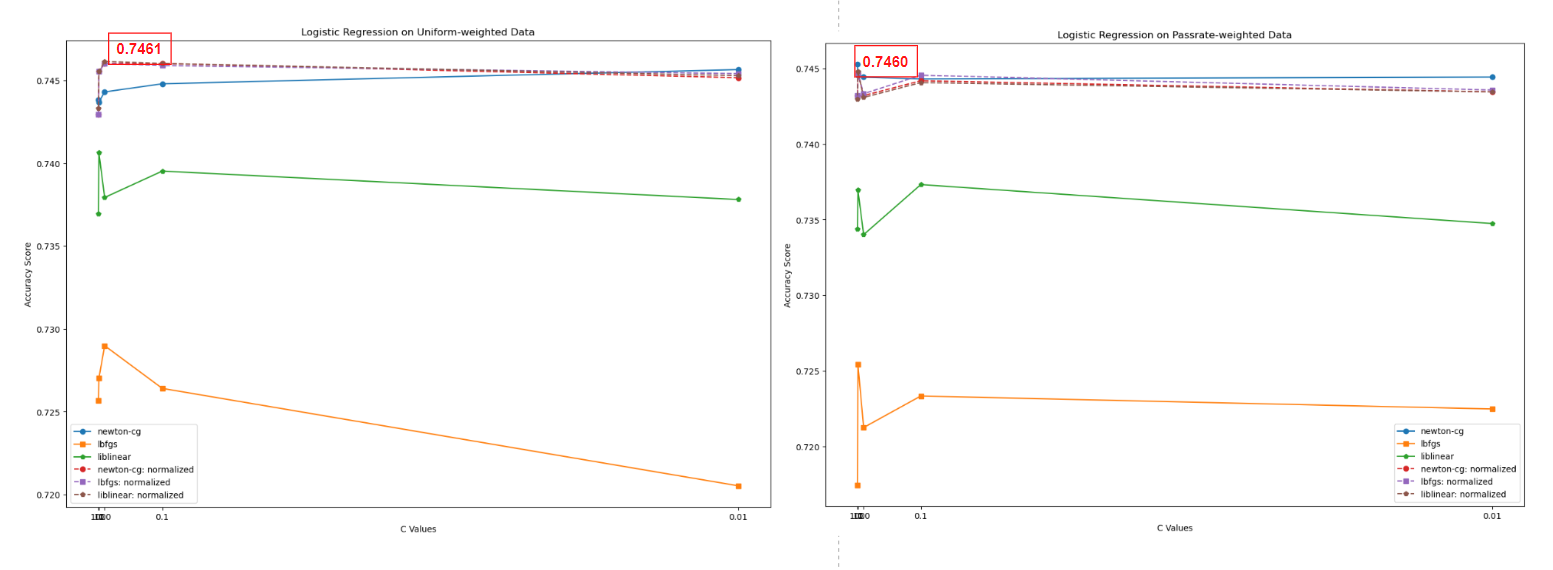

ref: https://saturncloud.io/blog/the-choice-of-the-optimal-solver-for-logistic-regression-fitted-to-mnist/#:~:text=newton%2Dcg%3A%20This%20solver%20uses,and%20supports%20multinomial%20logistic%20regression.  

1. The best accuracy score has reached 0.746(normalized uniform-weighted dataset with lbfgs solver and C set to 1.0), lower than the peak from Decision Tree models. 
2. With logistic regression, weighted data set carries out worse learning result than uniform-weighted data, especially when the regressor solver is set to 'lbfgs' and 'liblinear'.
3. Normalized data set has better learning result and more accurateand stable predictions. This is due to the vanishing gradient problem during the training phase without normalizetion(ref: https://www.google.com/search?q=do+we+need+to+normalize+data+for+logistic+regression&oq=do+we&gs_lcrp=EgZjaHJvbWUqCwgAEEUYJxg7GIoFMgsIABBFGCcYOxiKBTIGCAEQRRg5MgcIAhAAGIAEMgcIAxAAGIAEMgcIBBAAGIAEMgYIBRBFGDwyBggGEEUYPDIGCAcQRRg80gEIMTU0N2owajeoAgCwAgA&sourceid=chrome&ie=UTF-8).   
3. Among three solvers we tested, newton-cg and lgbfs are better than liblinear. This matches conclusions that "In general, if the dataset is small and the number of features is not too large, then the lbfgs or newton-cg solvers are good choices. If the dataset is large, then the sag or saga solvers are better choices."

From this section, we will use normalized data set for further experiment.  

### 3.2 Decision Tree

In [ ]:
depths = [2, 3, 5, 10, 15, 20]
min_splits = [10, 20, 30, 50, 100, 200]
criterions = ["gini", "entropy"]

for criterion in criterions:
    for split in min_splits:
        print("Criterion: {} minimum_split: {}".format(criterion, split))
        accuracy_scores = []
        for depth in depths:
            print("depth: {}".format(depth))
            tree_params = {'max_depth': depth, 'criterion': criterion, 'min_samples_split': split}
            model = DecisionTreeClassifier(**tree_params)
            
            results = cross_validate(model, norm_weighted_x_train, uniform_y_train, cv=5, scoring=scoring)
            accuracy_scores.append(np.mean(results["test_accuracy"]))
        print("Accuracy by depth: {}".format(accuracy_scores))

**Decision Tree on Uniform-Weighted Data**
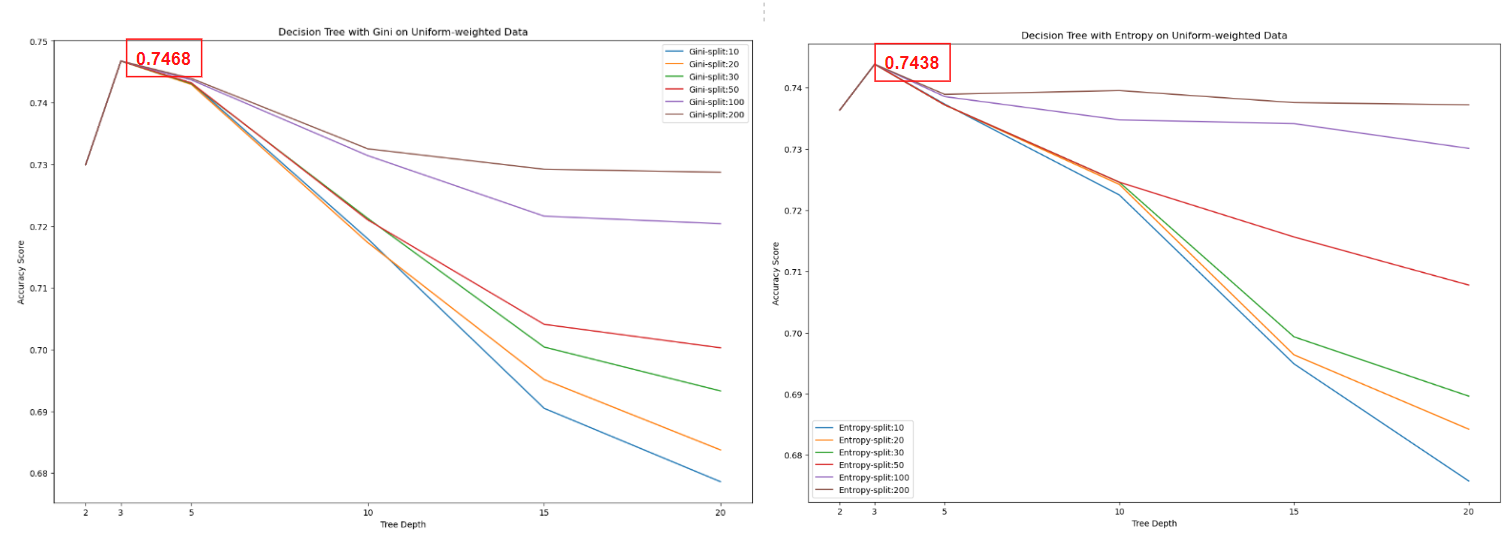
**Decision Tree on Passrate-Weighted Data**
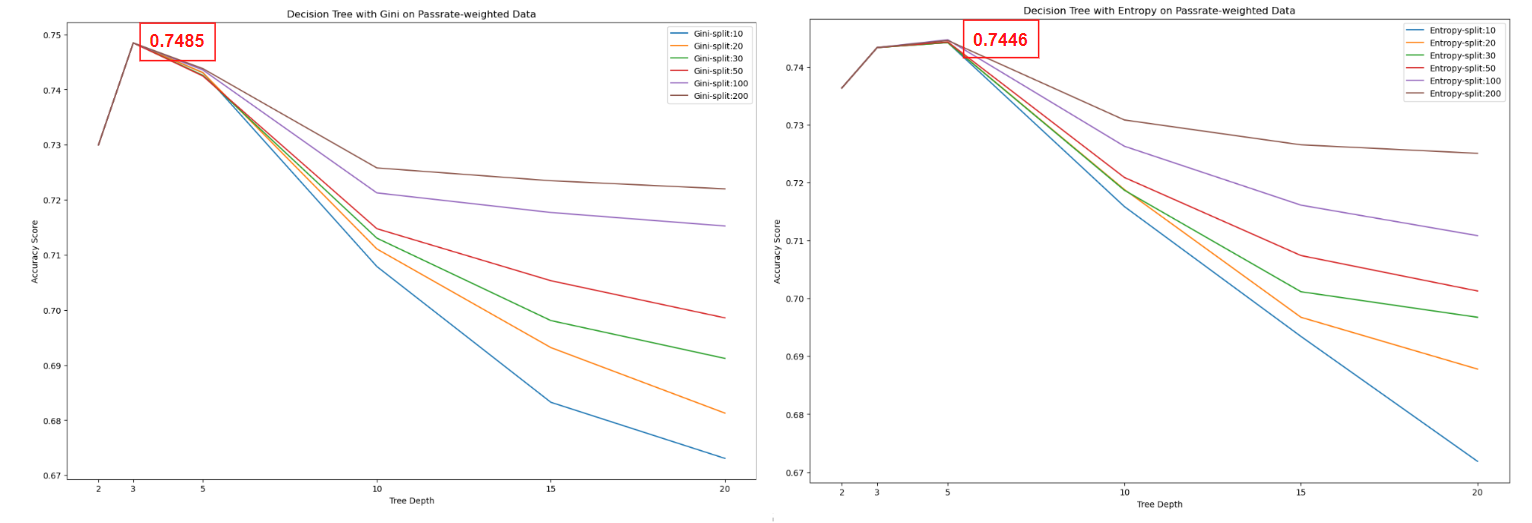

1. On our data model, Decision Tree with Gini algorithm performs generally better than Entropy.
2. Passrate-weighted data improves the classifier behaviour at a small improvement on accuracy scores. 
3. Accuracy drops as the tree depth grows, and climbs up as the minimum split sample amount increases. 
4. The best accuracy score is at 0.7485 on passrate-weighted data, with tree's hyperparameter set to (gini, depth=3), slightly better than logistic regression.
5. Since all curves are based on the performances on the same data set with k-fold, we could only say that one is more stable than the others. But cannot give conclusions for overfitting and underfitting.

### 3.3 Naive Bayes

In [14]:
multinomial_nb =  MultinomialNB()
complement_nb = ComplementNB()
gaussian_nb = GaussianNB()
bayes_models = [multinomial_nb, complement_nb, gaussian_nb]

x_data_sets = {"uniform": norm_uniform_x_train, "weighted": norm_weighted_x_train}

for key, data in x_data_sets.items():
    for model in bayes_models:
        results = cross_validate(model, data, uniform_y_train, cv=5, scoring=scoring)
        accuracy_scores = np.mean(results["test_accuracy"])
        print("Data: {}; Model: {}; Accuracy: {}".format(key, model, accuracy_scores))


Data: uniform; Model: MultinomialNB(); Accuracy: 0.7257948028997007
Data: uniform; Model: ComplementNB(); Accuracy: 0.7307005956889194
Data: uniform; Model: GaussianNB(); Accuracy: 0.6864455224149746
Data: weighted; Model: MultinomialNB(); Accuracy: 0.7153753561510442
Data: weighted; Model: ComplementNB(); Accuracy: 0.7267773740397446
Data: weighted; Model: GaussianNB(); Accuracy: 0.6423166798908404


Naive Bayes generally have weaker performance among the classifiers we tested.    

Gaussian Naive Bayes is used when we assume all the continuous variables associated with each feature to be distributed according to Gaussian Distribution. However, Gaussian Naive Bayes here performs the worst, especially on the weighted data set. This implies that our data model does not follow Gaussian Distribution.

Complement Naive Bayes have the highest accuracy scores, as they work well especially when the dataset is imbalanced. 

For Naive Bayes, uniform-weighted data works better.   
We will test GaussianNB for ensemble, since it has the worst performance. The goal is to figure out if ensemble learners can improve learning on non-Gaussian distributed data by Gaussian method. The guess for now is no.

### 3.4 Knn

In [ ]:
k_values = [1, 7, 9, 15, 19, 100, 250, 300, 1000, 3000, 4000]
dist_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

for metric in dist_metrics:
    accuracy_scores = []
    print("Distance: {}".format(metric))
    for k in k_values:
        params = {'n_neighbors': k, 'weights': 'distance', 'metric': metric}
        model = KNeighborsClassifier(**params)
            
        results = cross_validate(model, norm_weighted_x_train, uniform_y_train, cv=5, scoring=scoring)
        accuracy_scores.append(np.mean(results["test_accuracy"]))
    print("Accuracy by n_neighbors: {}".format(accuracy_scores))

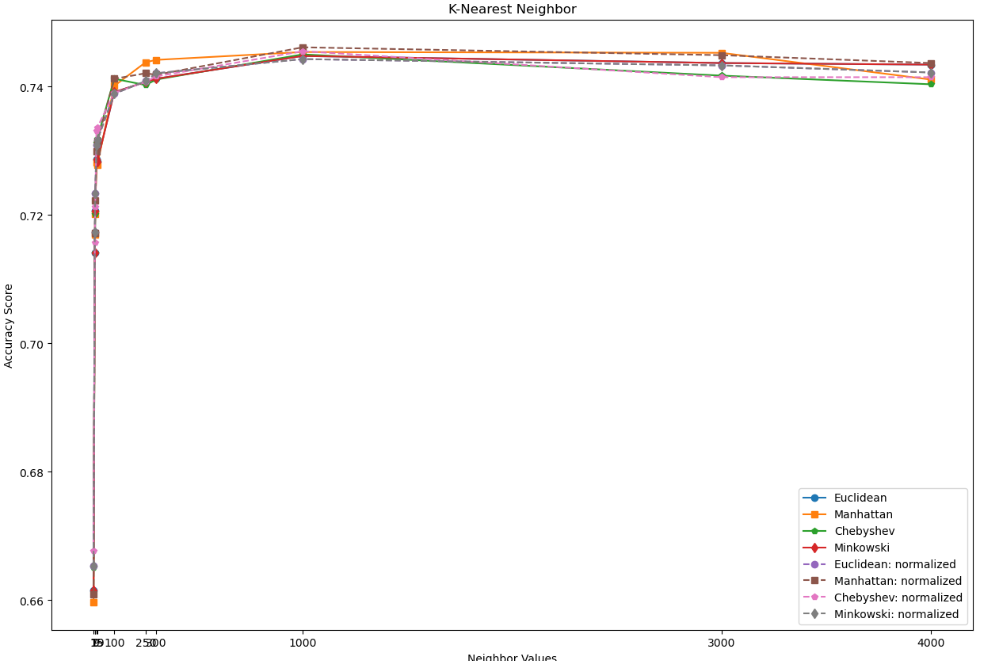
1. Performances with different distance metrics are similar; Among them Manhattan distance carries out the best results. The combination of Manhattan distance metric on weighted data has the highest accuracy at 0.7461. Manhattan distance is usually preferred over Euclidean distance when we have a case of high dimensionality.
2. Accuracy scores raise first as the neighbor amount grows, then slightly drops when the neighbor amount reaches almost 1/3 of the data set amount(overfitting).
3. When neighbor amount is set to 1, the whole model is underfitting.

### 3.4 Section Conclusion

ref: https://towardsdatascience.com/which-models-require-normalized-data-d85ca3c85388#:~:text=Logistic%20regression%20requires%20normalization%20as,problem%20during%20the%20training%20phase.&text=If%20you%20train%20a%20linear,as%20indicators%20of%20feature%20importance.  

1. Data sets will be normalized in later sections. Since some algorithms(classifiers) we will use later has involved distance calculation. In that case, we need to normalize our data as some models are sensitive to the order of magnitude of the features.
2. Uniform-weighted data performs better for Logistic Regression and Naive Bayes. Passrate-weighted data works better with Dicision Tree. And both data sets works similar for K-Nearest Neighbor. Therefore both data sets will be used for ensemble and deep learning. We could see this as a form of ablation study, to determine whether level passrates have positive impact over our model.
3. Since most of the accuracy scores in the previous experiments are above 0.7, we need to pay extra care to avoid overfitting in ensemble learning.

## 4. Ensemble Learning

ref: https://stats.stackexchange.com/questions/77018/is-random-forest-a-boosting-algorithm#:~:text=Random%20Forest%20is%20a%20bagging,to%20achieve%20a%20low%20error.  

We know that error can be composited from bias and variance. A too complex model has low bias but large variance, while a too simple model has low variance but large bias, both leading a high error but two different reasons. As a result, two different ways to solve the problem come into people's mind (maybe Breiman and others), variance reduction for a complex model, or bias reduction for a simple model, which refers to random forest and boosting.

We will use three ensemble learners in this section: RandomForest and Bagging. 
Below listed the combinations of base classifiers, hyperparamters and data sets we are using:
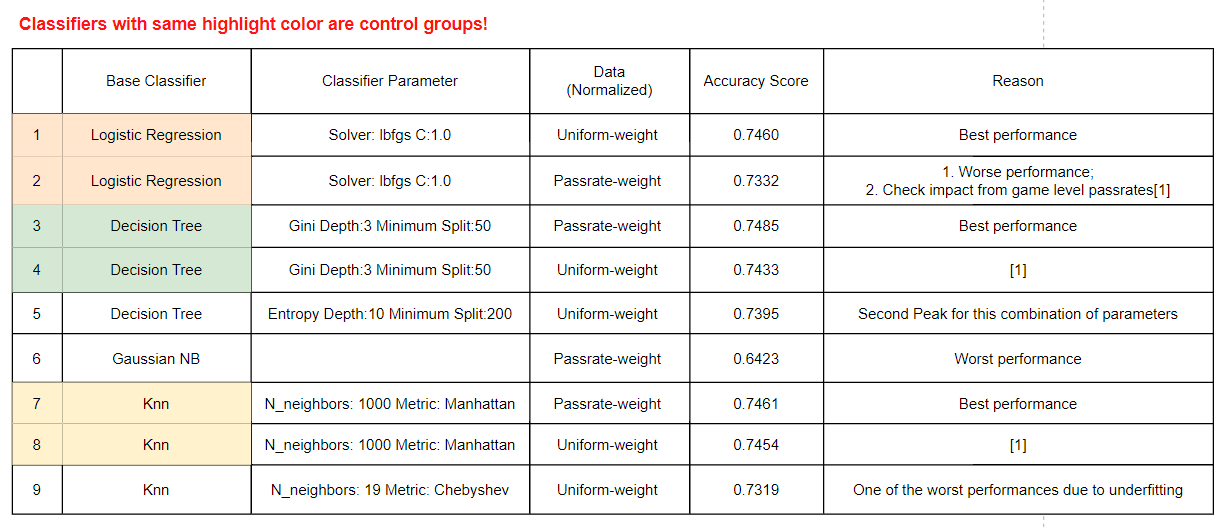

In this section, learning results will be evaluated on the validation set.


In [11]:
# normailize validation set
uniform_x_val = uniform_validation_df.drop(columns=["label", "user_id"]).to_numpy()
uniform_y_val = uniform_validation_df["label"].to_numpy()

weighted_x_val = weighted_validation_df.drop(columns=["label", "user_id"]).to_numpy()
weighted_y_val = weighted_validation_df["label"].to_numpy()

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(uniform_x_train)
norm_uniform_x_val = scaler.transform(uniform_x_val)

scaler.fit(weighted_x_train)
norm_weighted_x_val = scaler.transform(weighted_x_val)

norm_uniform_x_val.shape, norm_weighted_x_val.shape, uniform_y_val.shape, weighted_y_val.shape

((2658, 13), (2658, 13), (2658,), (2658,))

In [38]:
# initialize base classifiers
lg_clf = LogisticRegression(solver='lbfgs', C=1.0)
decision_tree_1 = DecisionTreeClassifier(max_depth=3, criterion='gini', min_samples_split=50)
decision_tree_2 = DecisionTreeClassifier(max_depth=10, criterion='entropy', min_samples_split=200)
gaussian_nb = GaussianNB()
knn_clf_1 = KNeighborsClassifier(n_neighbors=1000, weights='distance', metric='manhattan')
knn_clf_2 = KNeighborsClassifier(n_neighbors=19, weights='distance', metric='chebyshev')

In [38]:
def draw_roc_auc_curves(fprs, tprs, all_auc, numbering, title):
    plt.title(title)
    
    for i in range(len(numbering)):
        plt.plot(fprs[i], tprs[i], label="Itr:{}".format(numbering[i]))
        plt.legend()
        plt.plot([0, 1], [0, 1],'r')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
    plt.show()

### 4.1 Random Forest

ref: https://stats.stackexchange.com/questions/77018/is-random-forest-a-boosting-algorithm#:~:text=Random%20Forest%20is%20a%20bagging,to%20achieve%20a%20low%20error.  

RandomForest is a form of bagging. It basically grows many classification trees, then each tree gives a classification, votes" for that class.  
We will directly use the hyperparameters from above base classifiers for this section.

In [ ]:
estimator_amount = [10, 15, 20, 25, 50, 100]

all_accuracy = []
all_auc = []
fprs = []
tprs = []

for n in estimator_amount:
    tree_params = {'n_estimators': n, 'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 200}
    model = RandomForestClassifier(**tree_params)

    model.fit(norm_weighted_x_train, weighted_y_train)
    y_hat = model.predict(norm_weighted_x_val)
    probs = model.predict_proba(norm_weighted_x_val)[:,1]

    accuracy = accuracy_score(weighted_y_val, y_hat)
    # auc score
    fpr, tpr, threshold = roc_curve(weighted_y_val, probs)
    auc_score = auc(fpr, tpr)
    
    all_accuracy.append(accuracy)
    all_auc.append(auc_score)
    fprs.append(fpr)
    tprs.append(tpr)

print("Accuracy: {}".format(all_accuracy))
print("AUC: {}".format(all_auc))
draw_roc_auc_curves(fprs, tprs, all_auc, estimator_amount, "AUC for RandomForest")

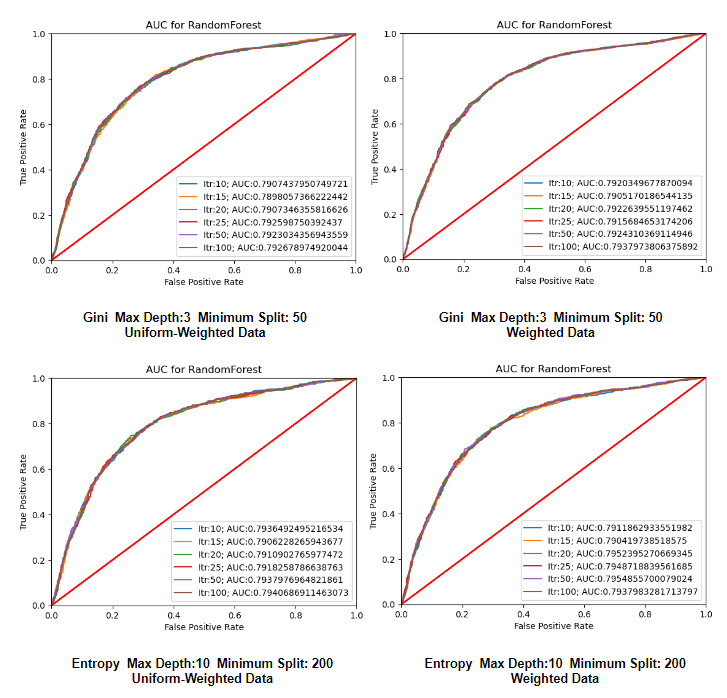
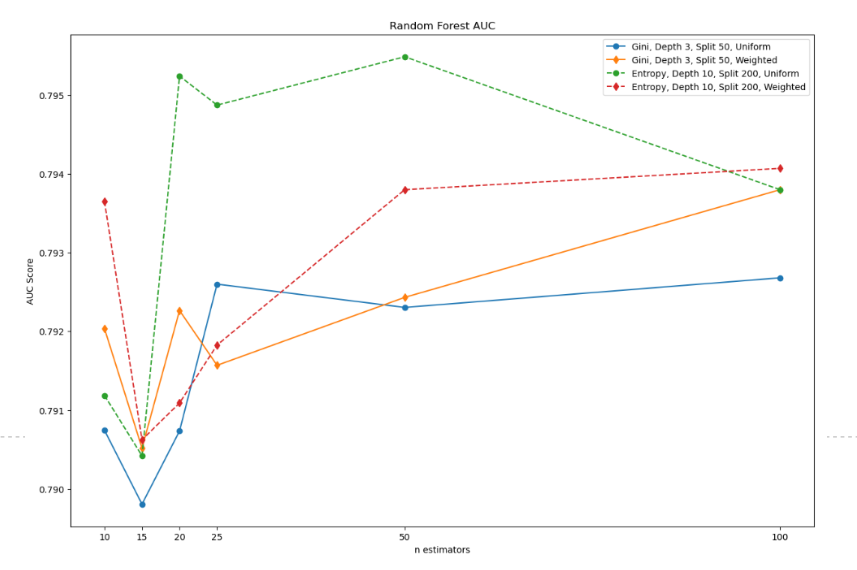

1. Compared to simple decision tree classifiers, both hyperparameter combination has improved. The weaker classifier improves more than the stronger one in RandomForest. The best accuracy is still with the stronger decision tree classifier with accuracy score at 0.7550.  

2. Weighted data set provides better learning results than uniform-weighted data.

3. Roc AUC curves are similar with different n_estimator values. AUC scores all drop down when estimator amount is set to 15 then climb up. Among what we tested, an entropy tree with depth at 10 and minimum split at 200 on uniform-weighted data, the AUC score reaches the highest at 0.7955 (n_estimator: 50).

4. It's fair to have the conclusion that accuracy and performance of a random forest model improve as the tree amount increases. 

5. We will test the best accuracy and best auc condition on test set later, observing if any overfitting can happen.

### 4.2 Bagging

Since we only have 13 features in total, we will not consider 'max_features' in parameter tuning. We will use 0.7 as max features.  
Estimator amount to be tested: [10, 15, 20, 25, 50, 100]

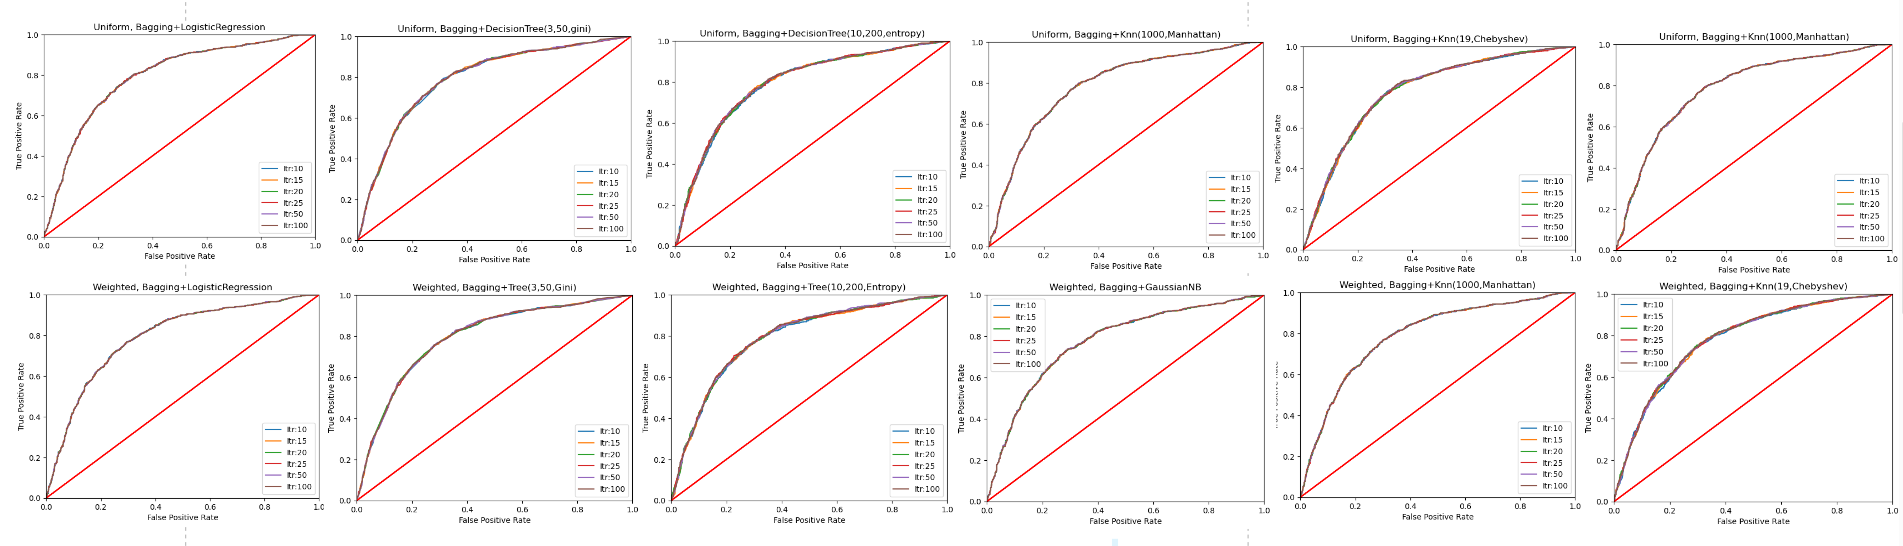
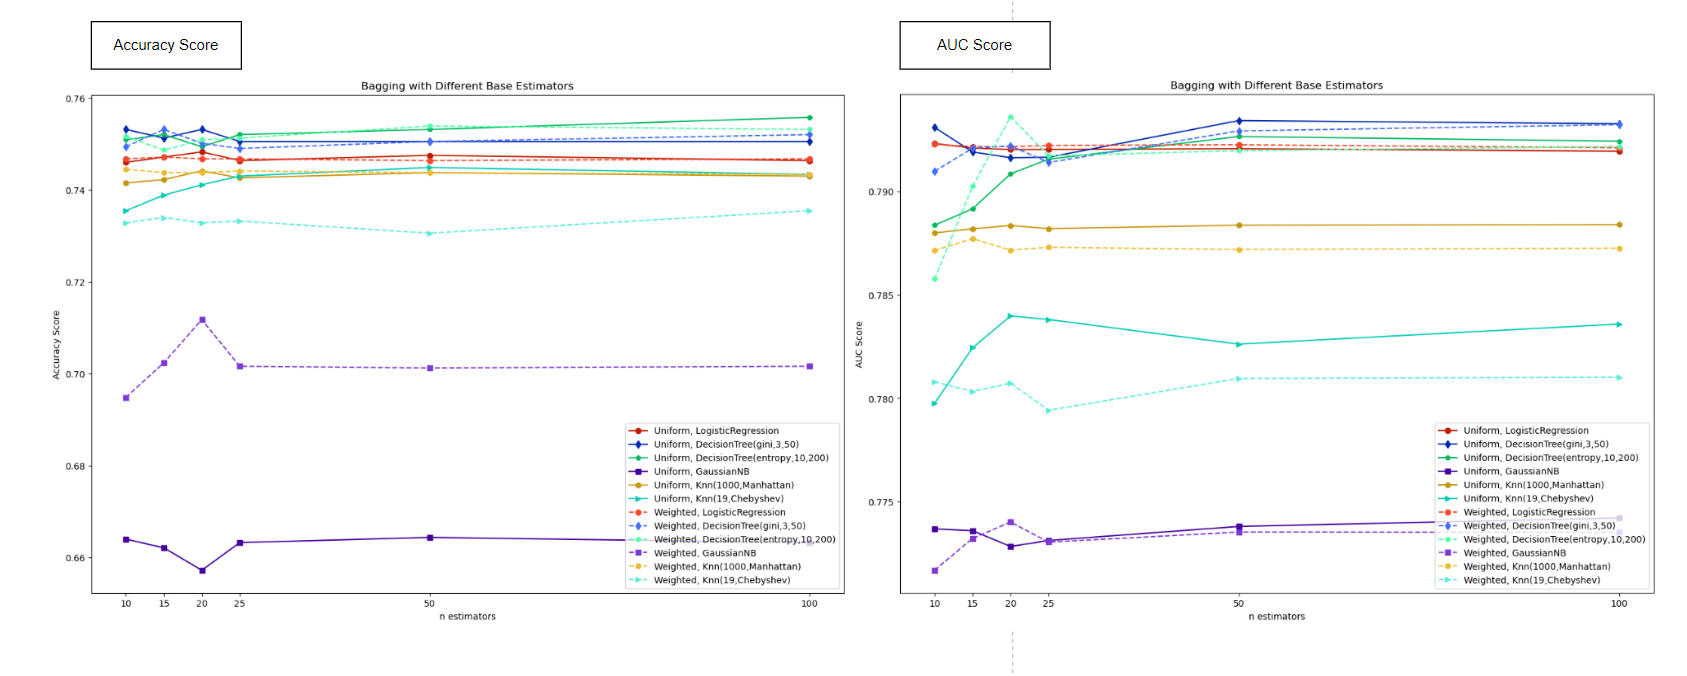

1. Compared to single classifiers, bagging ensemble has brought improvements on prediction accuracy for all classifier.
2. Gaussian Naive Bayes have better accuracy on weighted data model than uniform-weighted one. Gaussian Naive Bayes still have the lowest prediction accuracy and AUC scores. As we analyzed previoudly, our data does not follow a Gaussian distribution. Even ensemble brings in minor improvement, Gaussian Naive Bayes does not work with our data logically.
3. Knn with 1000 neighbors voting out the final classification has comparatively low AUC and accuracy, this is most likely caused by overfitting. 
4. Knn with Chebyshev distance and neighbor amount sets to 19 also does not have ideal performances. We could assume that Chebyshev does not work with our data and our task.
5. For logistic regression, decision tree(depth:3, minimum split:50, Gini) and decision tree(depth:10, minimum split:200, entropy), both accuracy scores and AUC scores follow a gentle upward trend as the estimator amount increases.  
6. For logistic regression and Knn, non-weighted data set gives better learing results. Decision tree and Gaussian Naive Bayes are the opposite.
7. The best accuracy score 0.7506 is with: Uniform-weight data, decision tree(depth:3, minimum split:50, Gini) and estimator amount set to 100.
8. The best AUC scores are:
> 0.7936: Weighted data, decision tree(depth:10, minimum split:200, Entropy) and estimator amount set to 20  
> 0.7929:Weighted data, decision tree(depth:3, minimum split:50, Gini) and estimator amount set to 50

### Section Conclusion

1. For all base classifiers, their AUC curves with different esitimator amounts do not differ too much. This is potentially because each classifier itself already gives a promising learning result.  
2. Ensemble learning genetally enhances the prediction accuracy as the esitimator amount grows. 
3. The best ensemble performances are all from decision tree.  
4. For decision tree based ensemble classifiers, weighted data contributes more positive impact than non-weighted data.
5. On test set, we will run: 
> Uniform-weight Data+RandomForest(depth:10,split:200,entropy) -- AUC:0.7955 Accuracy:0.7509  
> Weighted date+Bagging(estimator:50)+DecisionTree(depth:3,split:50,gini) -- AUC:0.7929 Accuracy: 0.7505  
> Weighted Data+Bagging(estimator:50)+LogisticRegression -- AUC:0.7923 Accuracy: 0.7464  

## 5.  MLP and RandomizedSearchCV for Hidden Layer Optimization

ref: https://saturncloud.io/blog/sklearn-mlp-classifier-hidden-layers-optimization-randomizedsearchcv/  

The Multi-Layer Perceptron (MLP) Classifier in Sklearn is a powerful tool that can be used for a wide range of classification tasks. However, optimizing the hidden layers of an MLP is often a challenging task. In this article, we will explore how to optimize the hidden layers of an MLP Classifier using RandomizedSearchCV in Sklearn.  

An MLP is a type of artificial neural network that consists of multiple layers of nodes. Each node in an MLP is a mathematical function that takes as input the weighted sum of the outputs of the nodes in the previous layer.  

One of the most important aspects of building an MLP Classifier is choosing the number and size of the hidden layers. The number of hidden layers and the number of nodes in each layer can have a significant impact on the performance of the model.  
A method that can be used to optimize the hidden layers of an MLP Classifier is RandomizedSearchCV. This method randomly samples a subset of hyperparameters and evaluates their performance. This approach is more computationally efficient than GridSearchCV and is ideal for large datasets.

In [66]:
"""To use RandomizedSearchCV for hidden layers optimization, we first need to define a parameter grid. 
The parameter grid specifies the hyperparameters we want to optimize and their possible values."""

hidden_layer_sizes = [(10,), (15,), (20,), (50), (100), 
                      (10, 10), (15, 15), (20, 20), (50, 50), (100, 100)]
param_grid = {'hidden_layer_sizes': hidden_layer_sizes}

In [68]:
mlp = MLPClassifier(max_iter=1000)
randomized_cv = RandomizedSearchCV(mlp, param_grid, n_iter=10, scoring='roc_auc')

In [69]:
randomized_cv.fit(norm_weighted_x_train, weighted_y_train)
print(randomized_cv.best_params_)

{'hidden_layer_sizes': 50}


In [70]:
randomized_cv.fit(norm_uniform_x_train, uniform_y_train)
print(randomized_cv.best_params_)

{'hidden_layer_sizes': (20, 20)}


We will use the optimizing results above to train our model. Below code is the same for both uniform data and weighted data, just the hyperparameter changes for hiddenlayer.

In [ ]:
activations = ['logistic', 'relu']
max_iters = [200, 250, 300, 400, 500, 800, 1000]

for activation in activations:
    print("activation: {}".format(activation, solver))
    auc_scores = []
    accuracy_scores = []

    for itr in max_iters:
        param = {'activation': activation, 'max_iter': itr, 'hidden_layer_sizes': (50,)}
        model = MLPClassifier(**param)
        model.fit(norm_weighted_x_train, weighted_y_train)

        y_hat = model.predict(norm_weighted_x_val)
        probs = model.predict_proba(norm_weighted_x_val)[:,1]

        accuracy = accuracy_score(weighted_y_val, y_hat)
        # auc score
        fpr, tpr, threshold = roc_curve(weighted_y_val, probs)
        auc_score = auc(fpr, tpr)

        auc_scores.append(auc_score)
        accuracy_scores.append(accuracy)

    print("accuracy: {}".format(accuracy_scores))
    print("auc: {}".format(auc_scores))

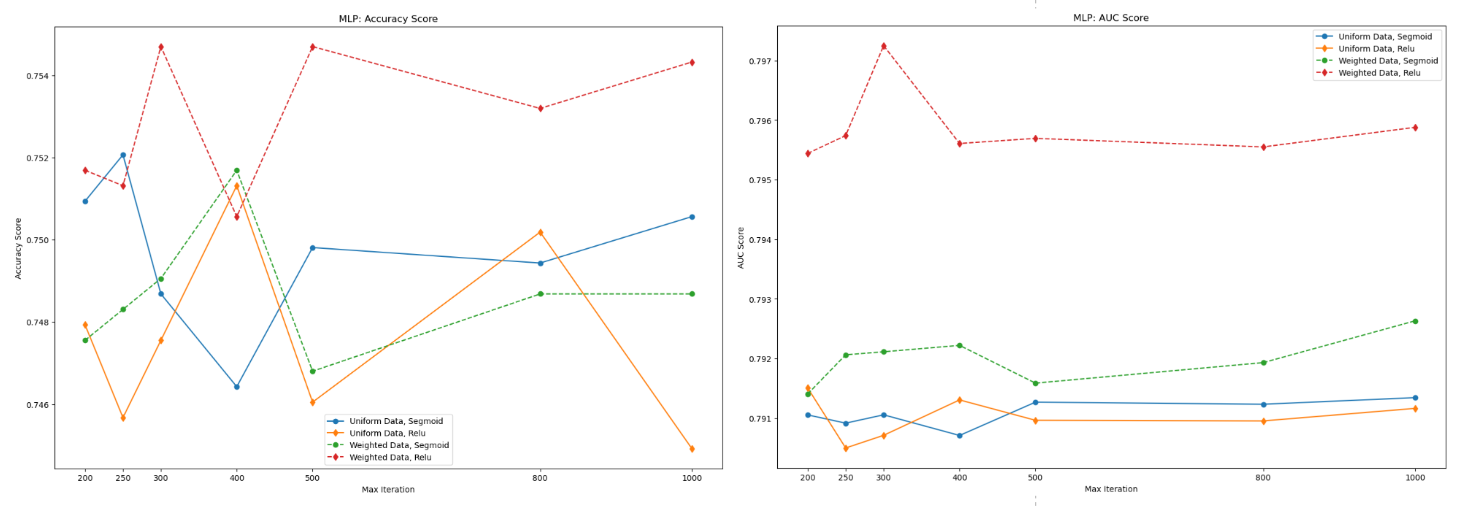

1. MLP with Relu activation on Weighted Data has the best performance, with the highest AUC at 0.7957 when max iteration is 250. This is also the highest AUC score among the experiments we run.
2. The accuracy scores fluctuate a lot for all hyperparameter combination. The AUC score generally follows an upward trend, drop down and then slowly climbs up again as the max iteration increases. 
3. From AUC perspective, weighted data contributes to better learning results compared to unwighted data. Also, Relu is better than Segmoid on our data model. Relu is known for faster calculation and faseter convergence. 
4. The weakest performance is MLP with Relu on unweighted data with 800 iterations, and the AUC is 0.7909.
5. We will run the best performance and the worst performance on test set.

## 6. On Test Set

### 6.1 Classifers on Test Set (Run Once)

In [34]:
# normailize validation set
uniform_x_test = uniform_test_df.drop(columns=["user_id"]).to_numpy()
weighted_x_test = weighted_test_df.drop(columns=["user_id"]).to_numpy()

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(uniform_x_test)
norm_uniform_x_test = scaler.transform(uniform_x_test)

scaler.fit(weighted_x_test)
norm_weighted_x_test = scaler.transform(weighted_x_test)

norm_uniform_x_test.shape, norm_weighted_x_test.shape

((2773, 13), (2773, 13))

In [32]:
result_df = pd.read_csv('./data/result.csv')
result_df = result_df.drop(columns=["Prediction"])

In [15]:
randomforest_model = RandomForestClassifier(n_estimators=50, max_depth=10, criterion='entropy', min_samples_split=200)

tree = DecisionTreeClassifier(max_depth=3, criterion='gini', min_samples_split=50)
bagging_tree = BaggingClassifier(tree, n_estimators=50, max_samples=0.7, max_features=0.7)

bagging_logistic = BaggingClassifier(
    LogisticRegression(solver='lbfgs', C=1.0), 
    n_estimators=50, max_samples=0.7, max_features=0.7)

mlp_relu_250itr = MLPClassifier(activation='relu', max_iter=250, hidden_layer_sizes=(50,))
mlp_relu_800itr = MLPClassifier(activation='relu', max_iter=800, hidden_layer_sizes=(50,))
mlp_segmoid_1000itr = MLPClassifier(activation='logistic', max_iter=1000, hidden_layer_sizes=(20,20))

In [114]:
bagging_tree.fit(norm_weighted_x_train, weighted_y_train)
proba = bagging_tree.predict_proba(norm_weighted_x_test)[:,1]

# output result csv
result_df["Prediction"] = proba
result_df.to_csv("./result_bagging_tree.csv", encoding='utf-8', index=False)

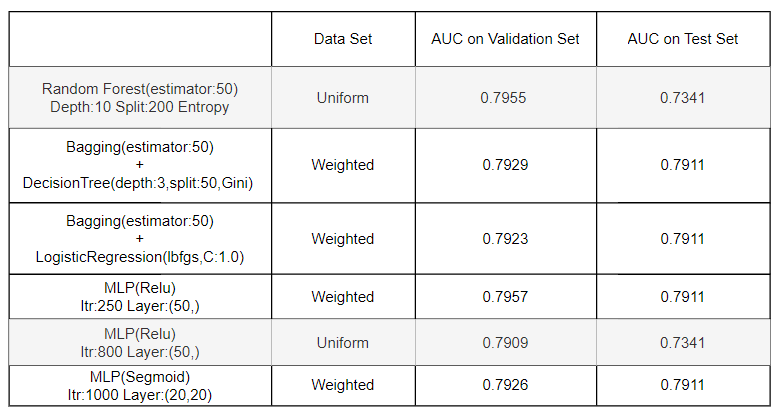
Seen from the diagram above, the best AUC score throughout the whole experiment becomes stable at 0.7911.  
AUC for two highlighted classifiers drop down massively from the validation set to the test set. This is where overfitting happens.   
If we want to further improve our data model, we need to consider re-construct our data set, since most of the experimented learning models have the same AUC on the test set.   

We will add in statistical significance tests on these models for better analysis, since most of the AUC scores are the same.  
ref: https://www.cnblogs.com/cecilia-2019/p/11720999.html  

### 6.2 Paired T-Test 

ref: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/  
Comparing machine learning methods and selecting a model is a common operation in applied machine learning.  

Models are commonly evaluated using resampling methods like k-fold cross-validation from which mean skill scores are calculated and compared directly. Although simple, this approach can be misleading as it is hard to know whether the difference between mean skill scores is real or the result of a statistical fluke.  

Statistical significance tests are designed to address this problem and quantify the likelihood of the samples of skill scores being observed given the assumption that they were drawn from the same distribution. If this assumption, or null hypothesis, is rejected, it suggests that the difference in skill scores is statistically significant.   

ref: https://towardsdatascience.com/paired-t-test-to-evaluate-machine-learning-classifiers-1f395a6c93fa  
Paired T-Test is a common way for statistical significance test method. Here, we run each model on the test set for 5 times. The more precise way is to use 20 to 30 test sets (k-fold), or a 5x2 coss validation. We only iterate 5 times here due to the time budget. 

In [77]:
# run each model for n times and record corresponding AUC, here n=5 (PS: we use percentage)
model1_auc_scores = np.array([0.79161, 0.79175, 0.78971, 0.79087, 0.79487])*100
model2_auc_scores = np.array([0.79057, 0.79173, 0.79360, 0.79102, 0.79214])*100
model3_auc_scores = np.array([0.78563, 0.78528, 0.78560, 0.78498, 0.78634])*100
model4_auc_scores = np.array([0.79089, 0.79029, 0.79161, 0.79179, 0.78776])*100
model5_auc_scores = np.array([0.78993, 0.79051, 0.78723, 0.79088, 0.79094])*100
model6_auc_scores = np.array([0.78891, 0.78912, 0.78864, 0.78900, 0.78904])*100

perform_scores = [model1_auc_scores, model2_auc_scores, model3_auc_scores, 
                  model4_auc_scores, model5_auc_scores, model6_auc_scores]

t_matrix = np.zeros((6,6))

for i in range(6):
    for j in range(6):
        if i==j:
            t_matrix[i,j] = 0
        else:
            diff = abs(perform_scores[i]-perform_scores[j])
            m = np.sum(diff)/5 # 5 is running for 5 times for each model
            sd = np.power(np.sum(np.power(diff-m, 2))/(5-1), 0.5)
            t = np.power(5, 0.5)*m/sd
            
            t_matrix[i,j] = t

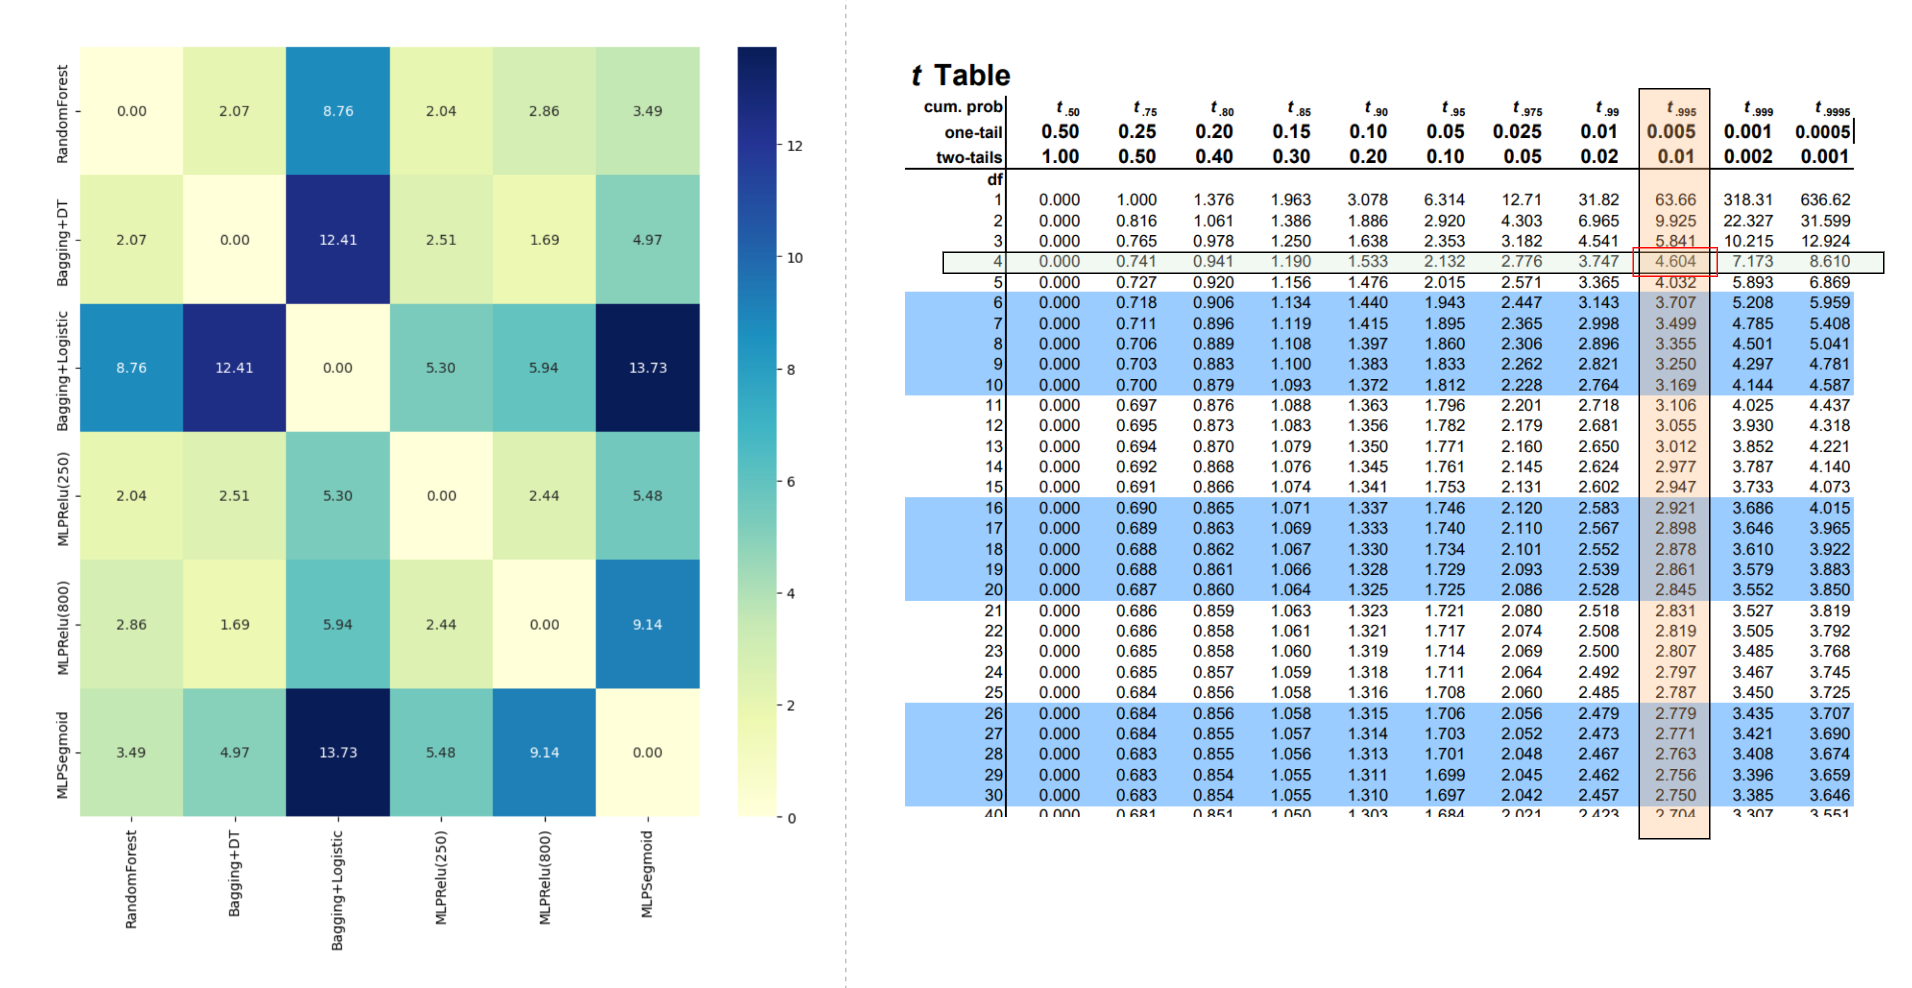

From the t-static values between the 6 models mentioned in Section 6 and compare with the t-table, there are some interesting observations:  
1. We assume a p-value = 0.05, and since we re-run each model for five times, the degree of freedom is set to 5-1=4. According to the table, if t between two pairs is within [-4.604, 4.604], we cannot reject the null hypothesis and there is no significant difference between our 2 classifiers.
2. RandomForest model has AUC in Section 6.1 at 0.7431. MLP(Relu, iter:250) and MLP(Segmoid, iter:1000) at the time has AUC both at 0.7911. Although there exists large difference between the AUC scores, the t values between RandomForest and these two models are within the score range, and there is no significant difference between them from a statistic point of view. MLP(Relu, iter: 800) has encountered similar situations. Again, this proves again that purely relies on the score value comparison can be misleading.
3. In Section 6.1, there are four models having the same AUC scores on the test set. They are:   
a. Bagging(estimator n=50) + DecisionTree(Gini, depth:3, minimum split:50)  
b. Bagging(estimator n=50) + LogisticRegression(solver: lbfgs, C: 1.0)  
c. MLP(Relu, iter=250, layer:(50,))  
d. MLP(Segmoid, iter=1000, layer:(20,20))  
> 3.1 Model b has rejected the null hypothesis and have significant differences with all the other models. The difference is most significant when paired with Model d.  
> 3.2 Model a has small differences with other models(except b), so does model c. 


### 6.3 Ablation Study on Features

We will drop only one feature at a time from the pool and use model b in Section 2 with T-test. This will run on the vaidation set.  

https://www.investopedia.com/terms/t/t-test.asp#:~:text=This%20calculated%20t%2Dvalue%20is,between%20the%20two%20sample%20sets.  The t-test questions whether the difference between the groups represents a true difference in the study or merely a random difference.  Higher values of the t-score indicate that a large difference exists between the two sample sets. The smaller the t-value, the more similarity exists between the two sample sets.

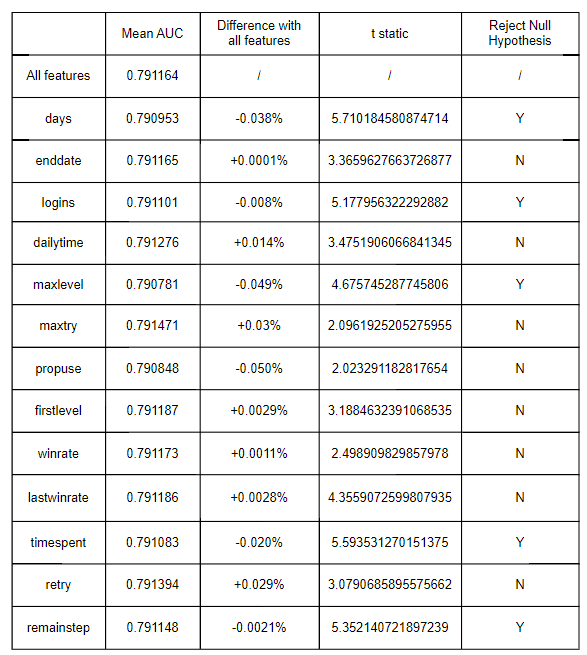

## 7. Conclusion

Under this task and with our constructed data model, ensemble algorithm and MLP works better than single classifiers. MOst of the best performances from Ensemble and MLP converge to the same AUC. 

The best AUC score is 0.7911 on test set. Bagging(estimator amount: 50) with Decision Tree(Gini, Depth:3, Minimum Split:50) as the base classifier and MLP(Relu activation, iterate: 1000, hidden layer: (20,20)) are more stable under this occasion.

Features in the constructed data do not have too close correlation with each other. Seen from the shapley diagram, they also do not have too large impact over the model output. The highest shapley is around 0.15 with feature `last win rate`. Therefore,  if we want to significantly improve learning results, it is mandatory to re-construct the data set. As we mentioned earlier, since the last win rate has more obvious influence over the classification stategy, the re-construction could start from there. For example, in random forest one could bias distribution from which you sample features to analyse towards the ones that you are interested in. Another potential method is to weighted features with significant influences by some per-level information generated from `last win rate`. A risk of this method is that we add in more correlation between `last win rate` and modified features. This bias may shadow the true rule of classification. There is an article "8 Ways to Improve Accuracy of Machine Learning Models" updated in 2023, we could also test if techniques mentioned can be used for our task.

Due to the limitation of time, we are not able to complete all planned experiments in this assignment. In the future, we'd like to try reconstruct the data model for LSTM learnig. It would also be interesting to do ablation study on a voting ensemble to see if learning results can be enhanced by a combination of multiple classifiers. 

## Extended Experiments

### Feature Engineering
Inspired by the article "8 Ways to Improve Accuracy of Machine Learning Models" mentioned above, we tested outlier removal and dimension promotion through polynomial.  
With polynomial expansion degree set to 4, the combination of Tree--depth:3, split:50 and Bagging--n:70, sample:0.7, feature:0.6 has produced the highest AUC 0.7935.

In [15]:
## auc: 0.7935 Tree--depth:3, split:50, Bagging--n:70, sample:0.7, feature:0.6
new_weighted_train_df = weighted_train_df.drop(columns=["user_id", "label"])

polynomy = PolynomialFeatures(degree=5)
new_feature_data = polynomy.fit_transform(new_weighted_train_df)
new_test_feature_data = polynomy.fit_transform(weighted_test_df.drop(columns=["user_id"]))

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(new_feature_data)
new_feature_data = scaler.transform(new_feature_data)
scaler.fit(new_test_feature_data)
new_test_feature_data = scaler.transform(new_test_feature_data)

tree = DecisionTreeClassifier(max_depth=3, criterion='gini', min_samples_split=50)
bagging_tree = BaggingClassifier(tree, n_estimators=70, max_samples=0.7, max_features=0.6)

bagging_tree.fit(new_feature_data, weighted_y_train)
proba = bagging_tree.predict_proba(new_test_feature_data)[:,1]

# output result csv
result_df["Prediction"] = proba
result_df.to_csv("./result_poly_baggingtree.csv", encoding='utf-8', index=False)

### Voting Ensemble and Ablation Study 



### Other Ways for Data Construct